In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pickle
import pandas_profiling
from IPython.display import display_html, HTML
from bs4 import BeautifulSoup
import urllib
import re
import json
import ast
from collections import Counter
import seaborn as sns


def load_data():
    csv_train = pd.read_csv("../Model/data/train.csv")
    csv_test = pd.read_csv("../Model/data/test.csv").assign(specific_death=None).assign(months_survival=None)
    return pd.concat([csv_train, csv_test], sort=True)


def generate_report_from_csv(csv, name):
    report = csv.profile_report(title="Dataset Profiling Report")
    report.to_file(output_file=name+".html")
    return report
    


def save_report(report, name):
    dbfile = open(name, "ab")
    pickle.dump(report, dbfile)
    dbfile.close()


def load_report(name):
    dbfile = open(name, "rb")
    report = pickle.load(dbfile)
    dbfile.close()
    return report


def show_html(html):
    display_html(HTML(str(html)))


def save_html(html, name):
    with open(name + ".html", "w", encoding="utf-8") as file:
        file.write(str(html))


def save_overview(soup):
    # <div id="overview-content" class="row variable">
    for container in soup.findAll(
        "div",
        attrs={
            "id": re.compile("overview-content"),
            "class": re.compile("row variable"),
        },
    ):
        container.prettify()
        show_html(container)
#         save_html(container, "overview")
    print("Saved overview html")


def save_variables(soup):
    # <div class="row variable">
    for container in soup.findAll("div", attrs={"class": re.compile("row variable")}):
        if container.p == None or container.p.get_text() == "Dataset info":
            continue
        variable_name = str(
            container.findAll("p", attrs={"class": re.compile("h4")})[0]
            .get_text()
            .split("\n")[0]
        )
        variable_name = "variables_overview/variable_" + variable_name
        show_html(container)
        break
#         save_html(container, variable_name)
    print("Saved variables htmls")
    
def remove_unused_columns(csv):
    used_variables = list(pd.read_csv('../Model/trained_models/Features_ExtraST_model.csv',index_col=0)['0'].values)
    used_variables.remove('missBIO2')
    used_variables = ['ID'] + used_variables
    return csv[used_variables]

def add_risk_groups(csv):
    csv['risk_group'] = np.array(['low']*int(csv.shape[0]/3)+['medium']*int(csv.shape[0]/3)+['high']*int(csv.shape[0]/3+2))
    return csv

In [236]:
csv = load_data()
csv = remove_unused_columns(csv)
csv = add_risk_groups(csv)
# report = generate_report_from_csv(csv, 'short_profiling_report')
# save_report(report, "short_report.pickle")
# report = load_report("short_report.pickle")
# soup = BeautifulSoup(report.html)
# save_overview(soup)
# save_variables(soup)

In [231]:
# Fonts settings
SMALLEST_SIZE = 9
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 22
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALLEST_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALLEST_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["figure.figsize"] = (16,9)

In [240]:
def plot(csv, c):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    plt.tight_layout(pad=6, h_pad=8.0)
    plt.grid(axis="y", alpha=0.75)
    tile = " ".join([l.capitalize() for l in c.replace("_", " ").split(" ")])
    fig.suptitle(tile)
    dtype = csv[c].dtype
    data = csv[c]
    if dtype == object:
        data = data.fillna("Missing")
    elif dtype == np.float64:
        bins = np.linspace(csv[c].min(), csv[c].max(), 100)
    for group_name, (ax, color, groups) in {
        "Low": (ax1, "green", ["low"]),
        "Medium": (ax2, "orange", ["medium"]),
        "High": (ax3, "red", ["high"]),
        "Summary": (ax4, "black", ["low", "medium", "high"]),
    }.items():
        data = csv[csv["risk_group"].isin(groups)][c]
        if dtype == object:
            sns.countplot(x=data.name, data=pd.DataFrame(data), ax=ax)
            for tick in ax.get_xticklabels():
                tick.set_rotation(45)
        elif dtype == np.float64:
            data.plot.hist(ax=ax, bins=bins, color=color)

        ax.axes.get_yaxis().set_visible(False)
        ax.set_title(group_name)
        plt.savefig("images/" + c + ".png")

0     absent
1    present
2     absent
3     absent
4     absent
Name: cutaneous_biopsy_ulceration, dtype: object object
0    scenario2
1    scenario3
2    scenario1
3    scenario1
4    scenario1
Name: scenario, dtype: object object
0    superficial_spreading
1    superficial_spreading
2    superficial_spreading
3                 spitzoid
4    superficial_spreading
Name: cutaneous_biopsy_histological_subtype, dtype: object object
0    0.90
1    3.75
2    0.50
3    0.50
4    0.60
Name: cutaneous_biopsy_breslow, dtype: float64 float64
0     1.0
1    16.0
2     NaN
3     NaN
4     NaN
Name: total_count_slnb_ldn, dtype: float64 float64
0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: visceral_metastasis_location, dtype: object object
0    0.0
1    2.0
2    NaN
3    NaN
4    NaN
Name: total_positives_slnb_ldn, dtype: float64 float64
0    brown
1      red
2    brown
3    brown
4    brown
Name: patient_hair_color, dtype: object object
0    absent
1       NaN
2    absent
3    absent
4    abs

C:\Users\Mateusz\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


0    female
1      male
2    female
3    female
4    female
Name: patient_gender, dtype: object object
0    320.0
1      NaN
2    172.0
3    193.0
4    208.0
Name: LAB2469, dtype: float64 float64
0    1.6
1    NaN
2    1.8
3    1.7
4    1.3
Name: LAB2544, dtype: float64 float64
0    2.282609
1         NaN
2    2.826087
3    2.034483
4    2.000000
Name: neutrofils_per_limfocits, dtype: float64 float64
0    absent
1       NaN
2    absent
3    absent
4    absent
Name: cutaneous_biopsy_neurotropism, dtype: object object
0    0.80
1     NaN
2    0.76
3    1.05
4    0.80
Name: LAB2467, dtype: float64 float64
0    1.84
1     NaN
2    2.30
3    2.90
4    2.00
Name: LAB1309, dtype: float64 float64
0          trunk
1          trunk
2          trunk
3    lower limbs
4    lower limbs
Name: primary_tumour_location_coded, dtype: object object
0    72.0
1     NaN
2    53.0
3    51.0
4    56.0
Name: LAB2476, dtype: float64 float64
0    0.12
1     NaN
2    0.04
3    0.08
4    0.09
Name: LAB2679, dtype:

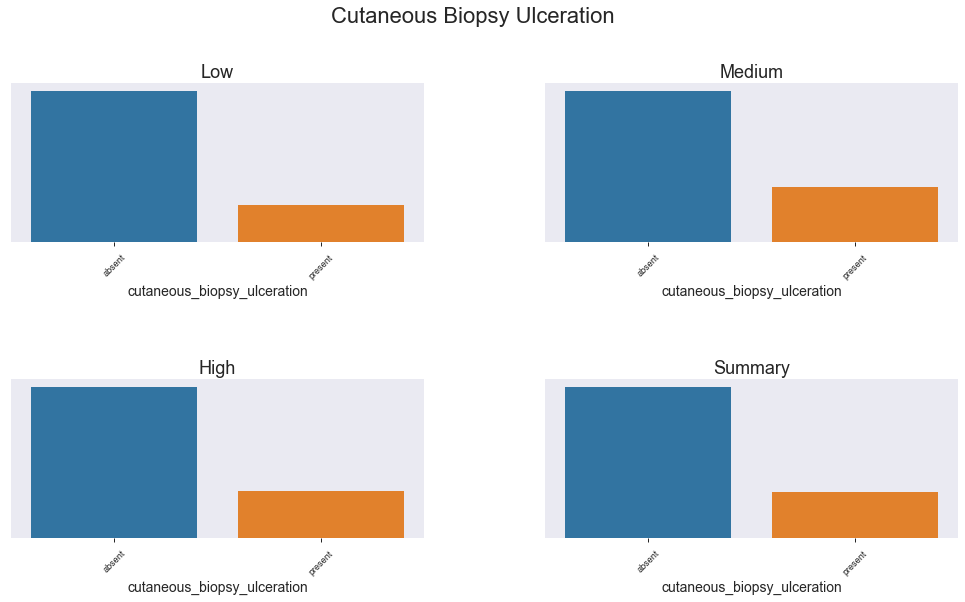

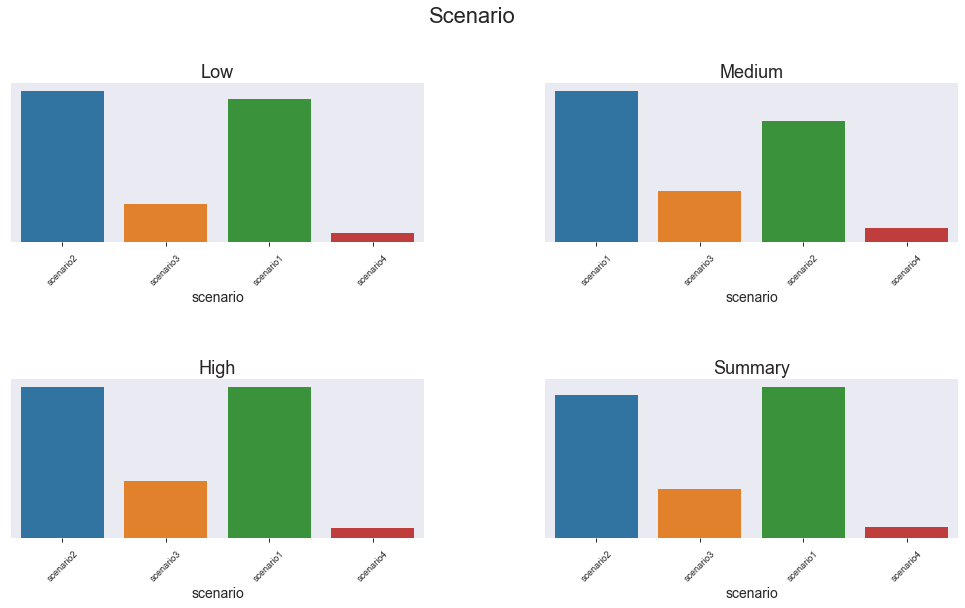

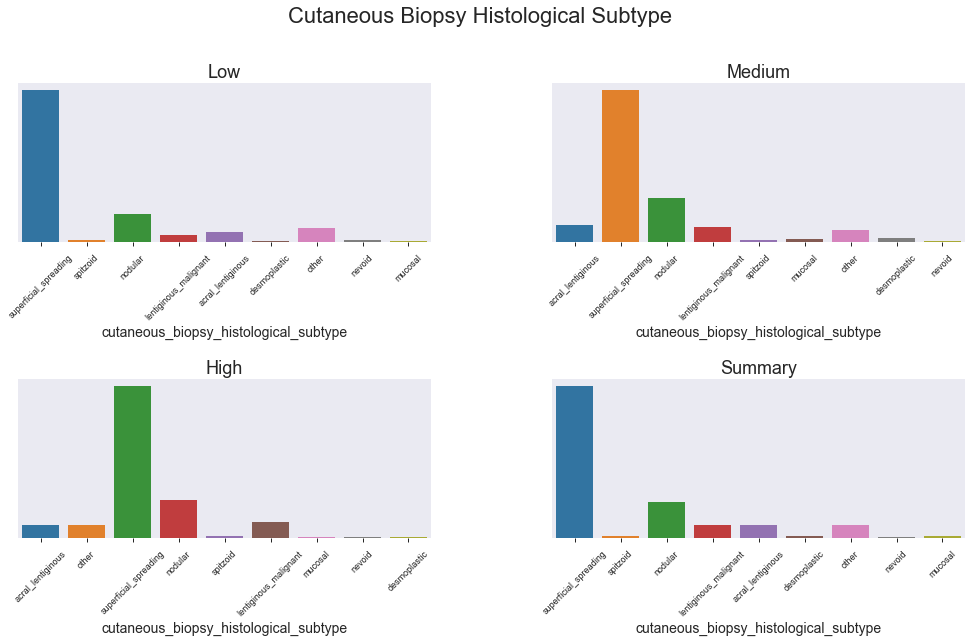

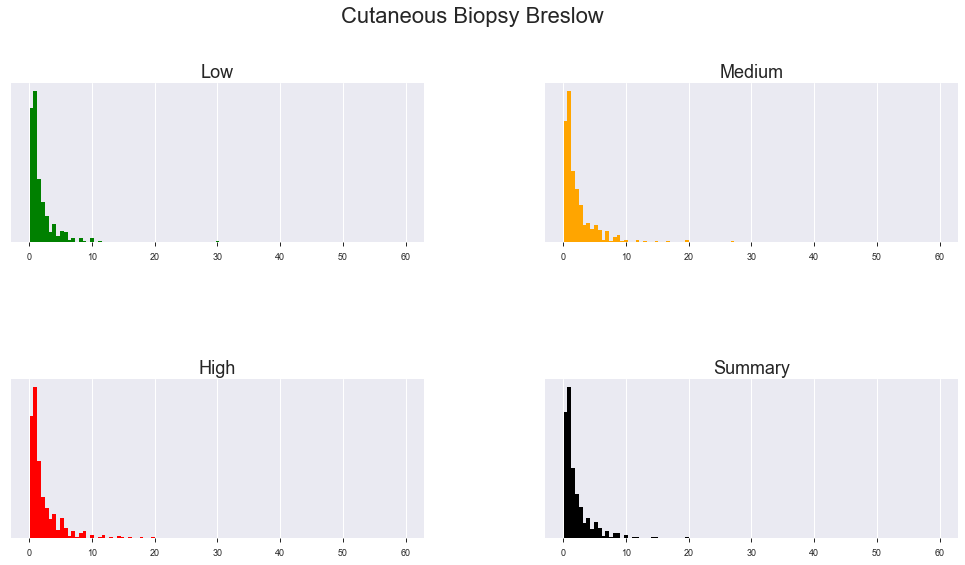

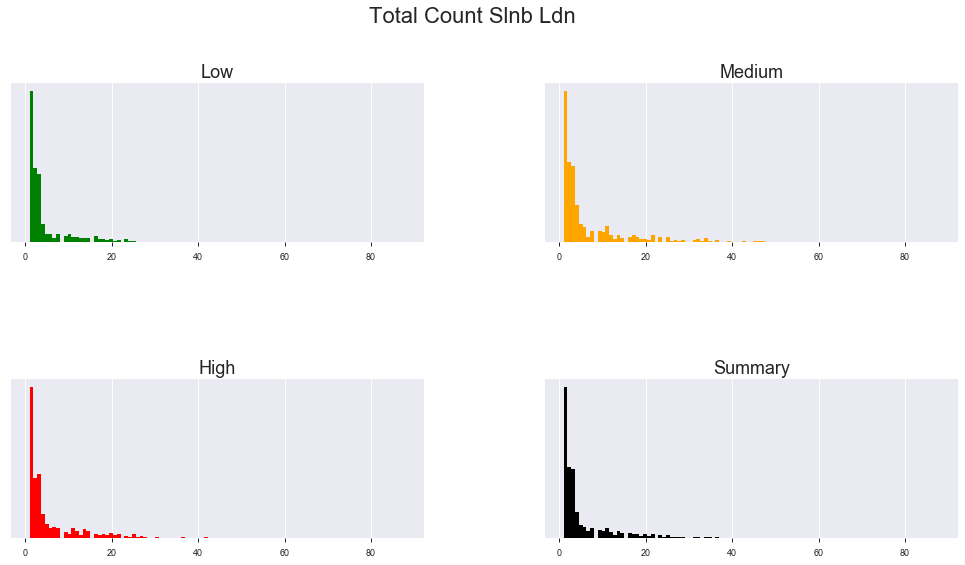

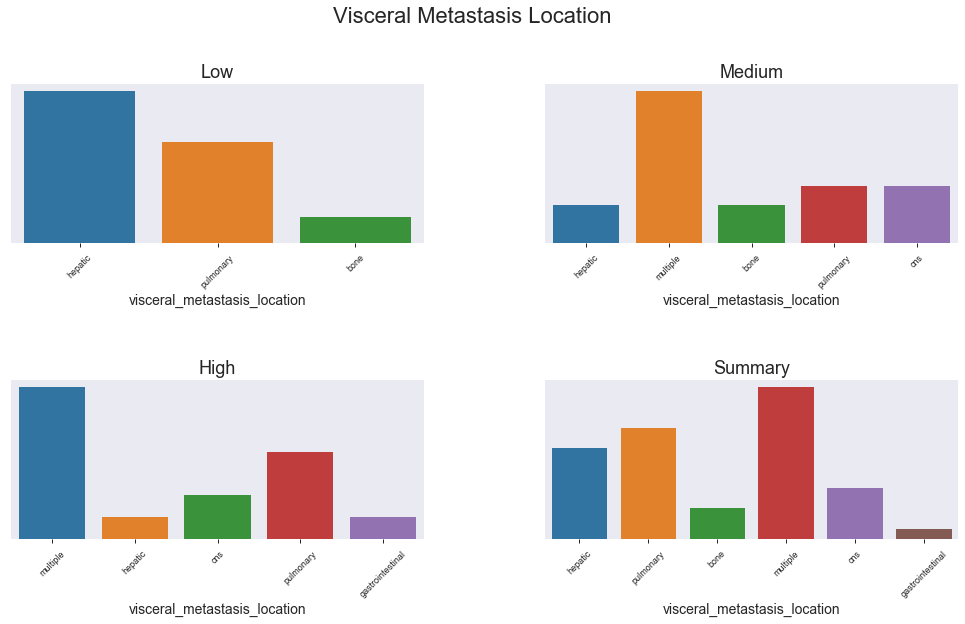

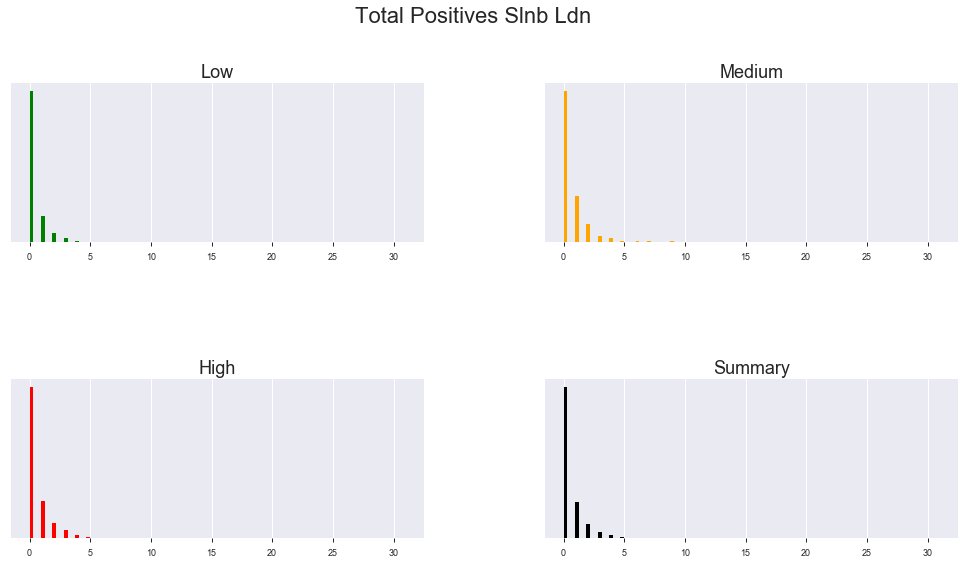

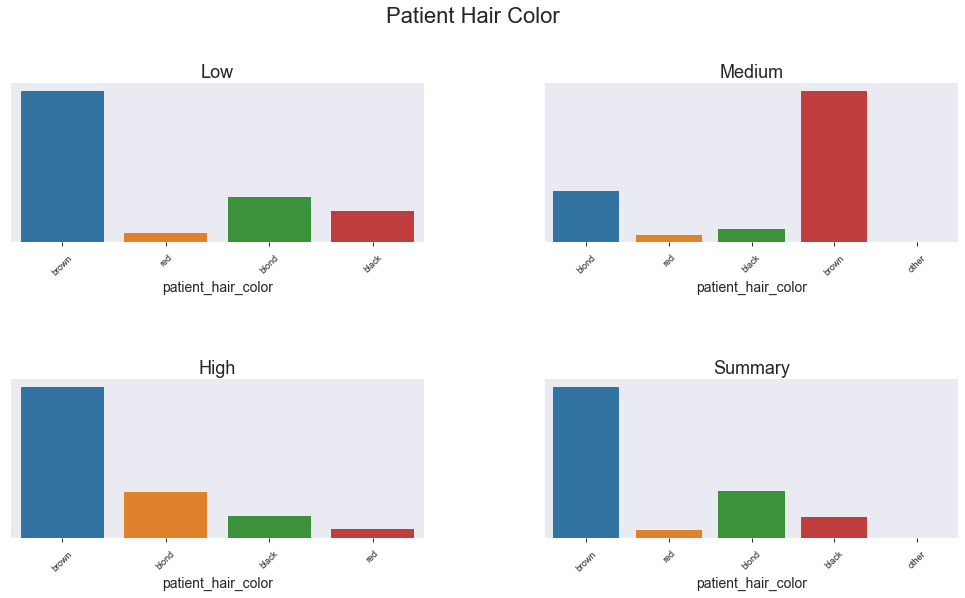

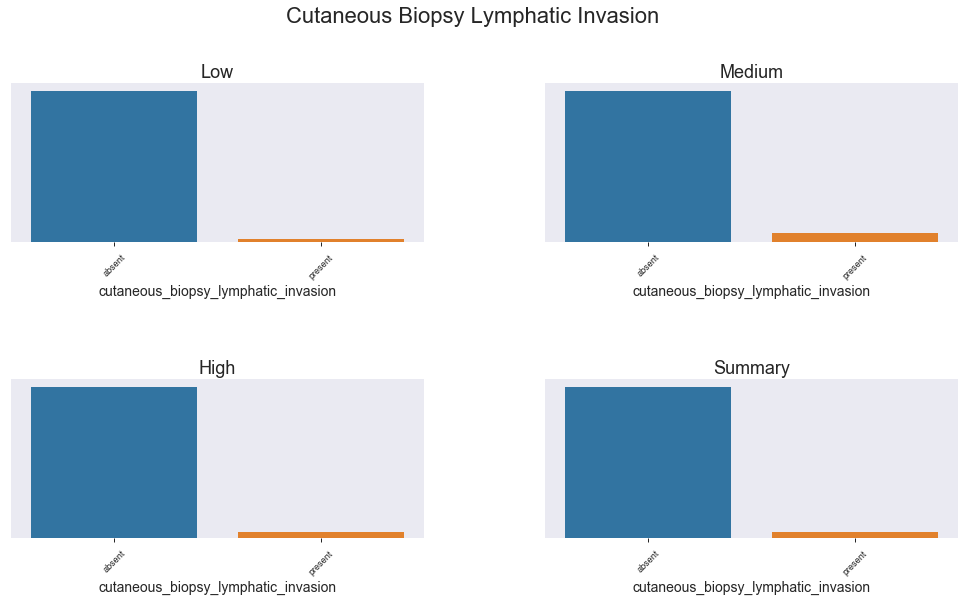

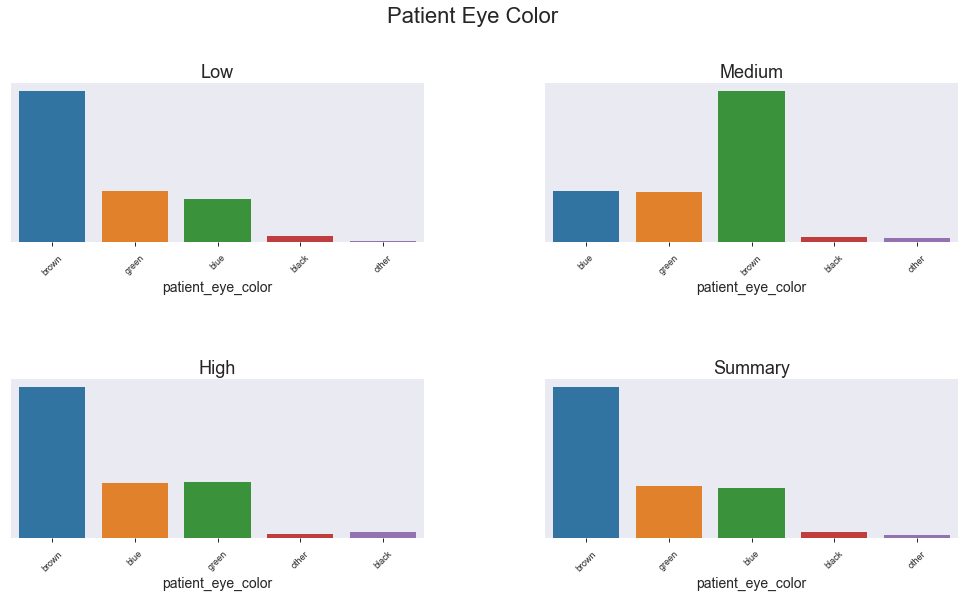

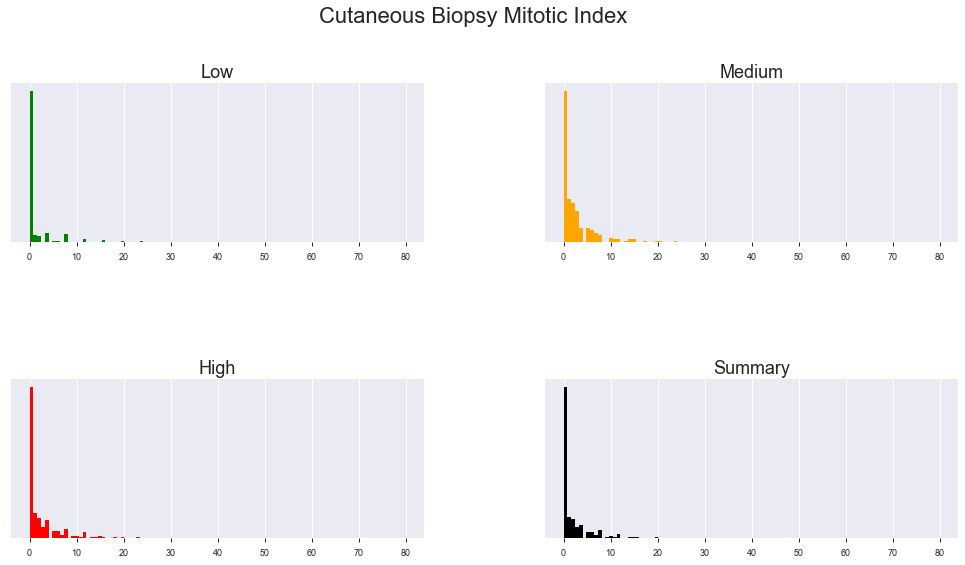

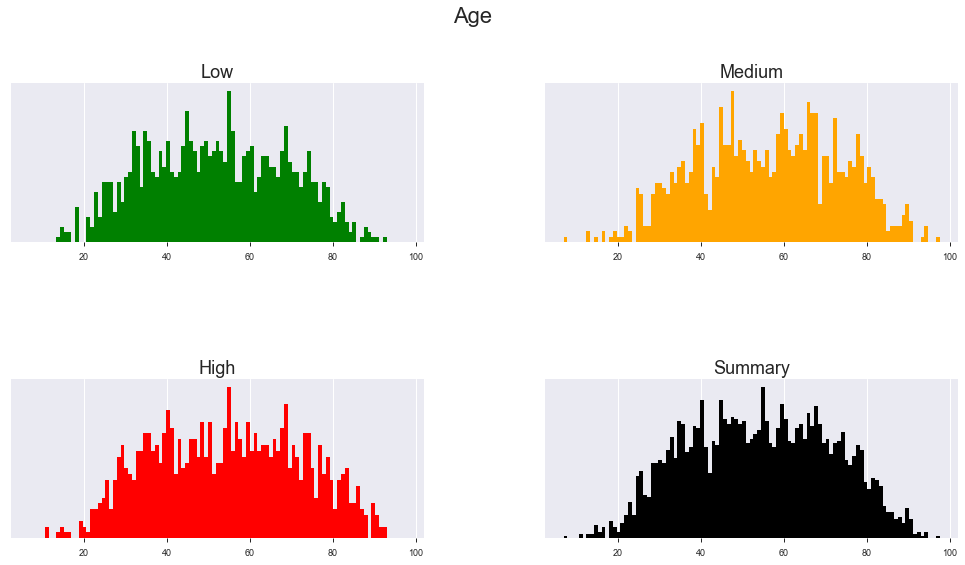

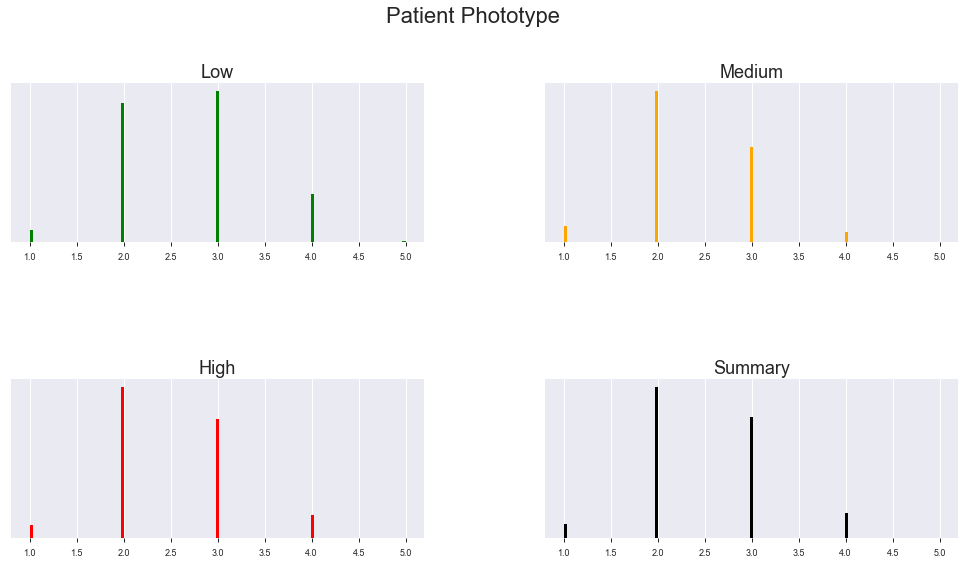

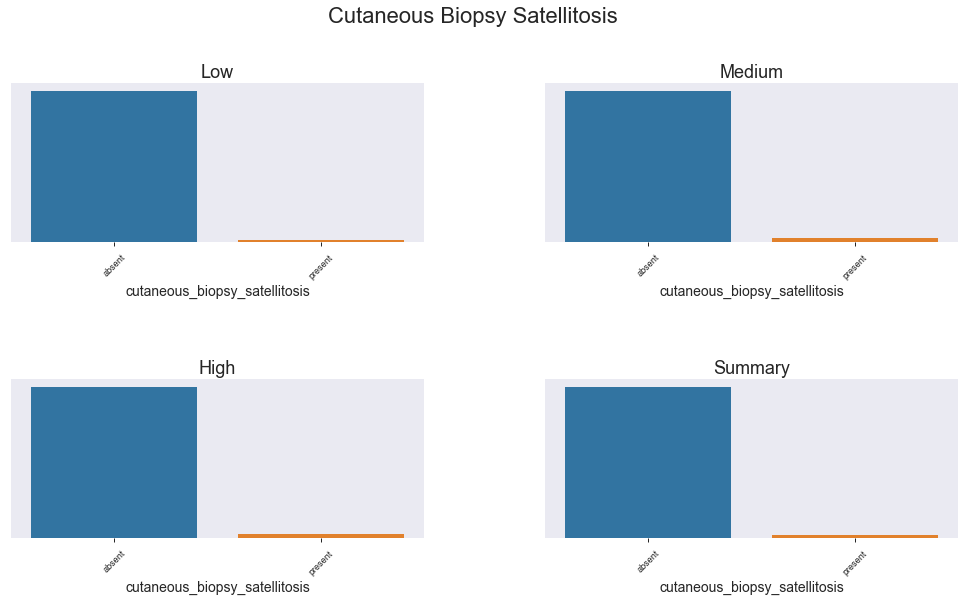

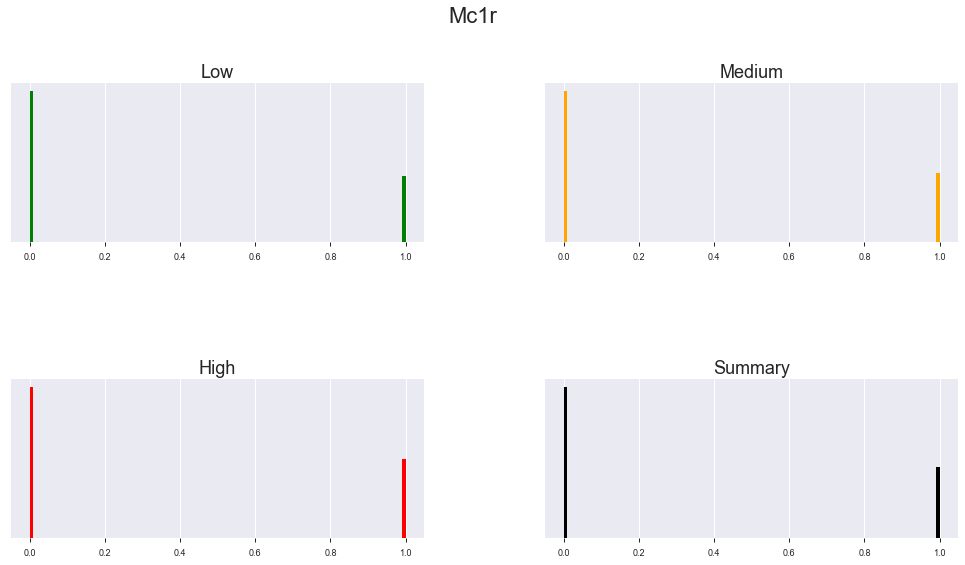

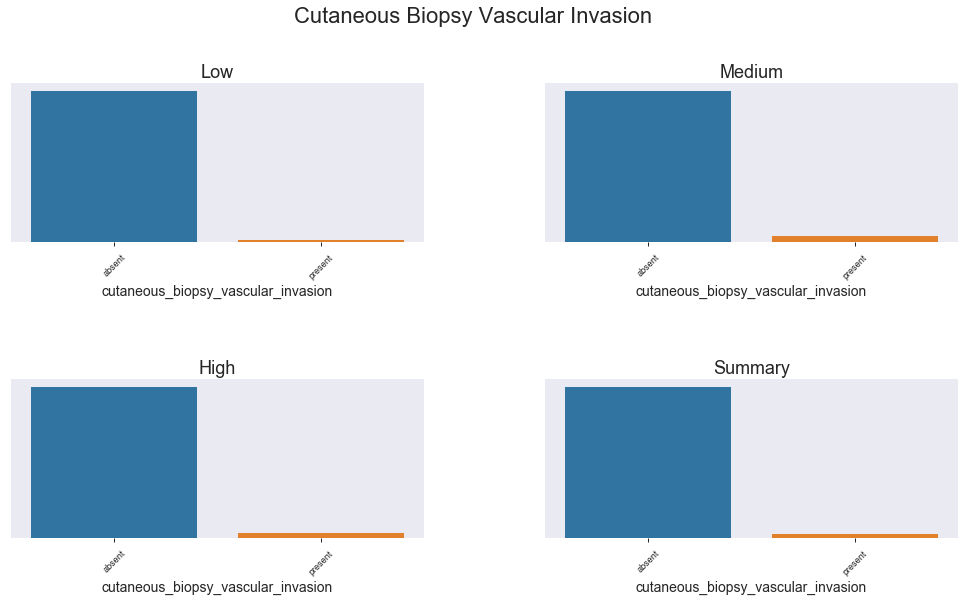

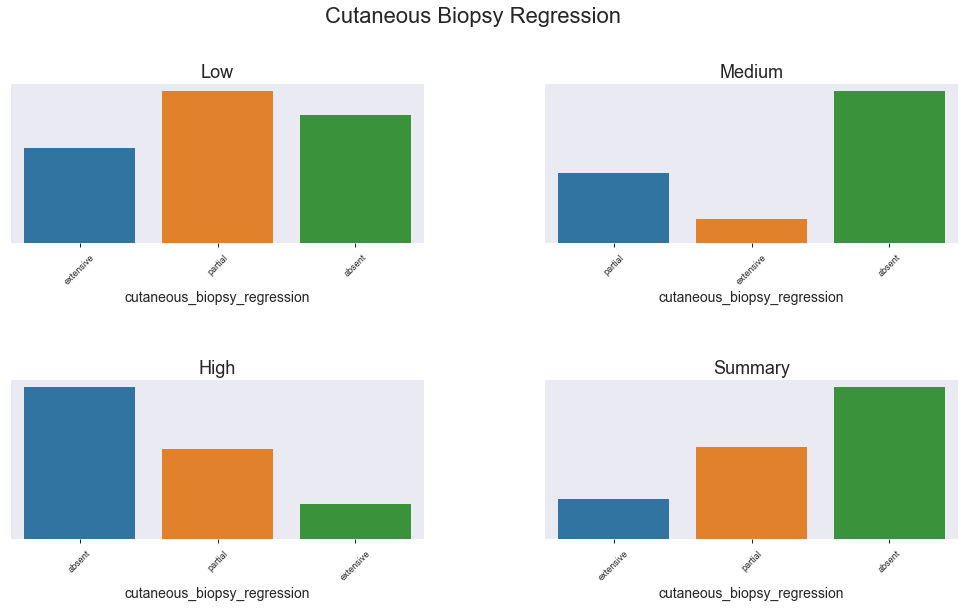

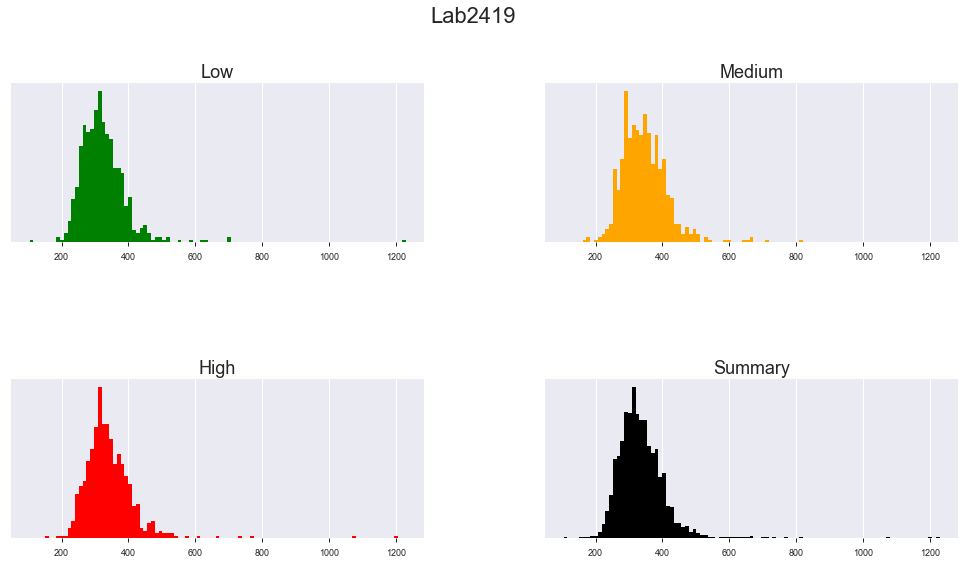

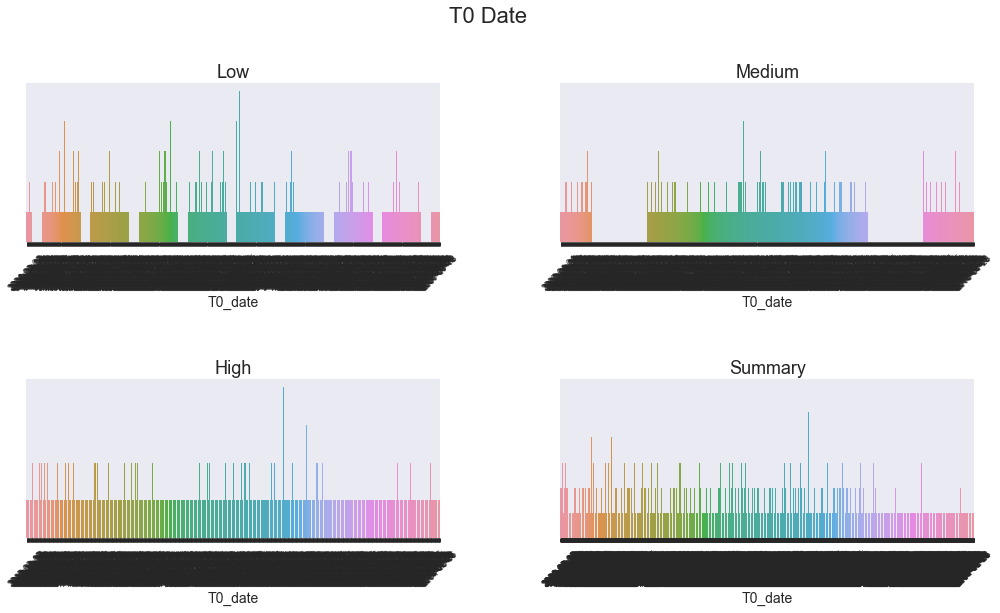

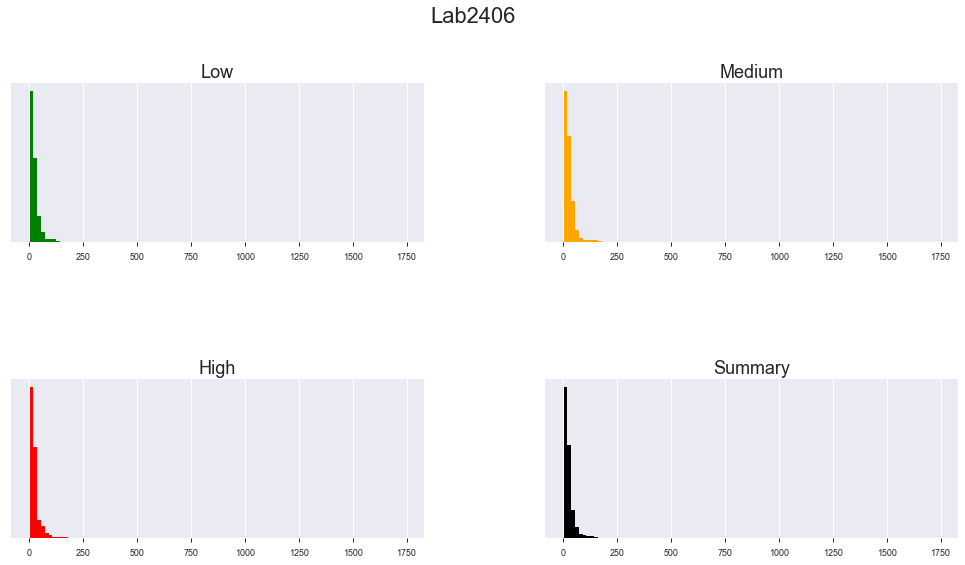

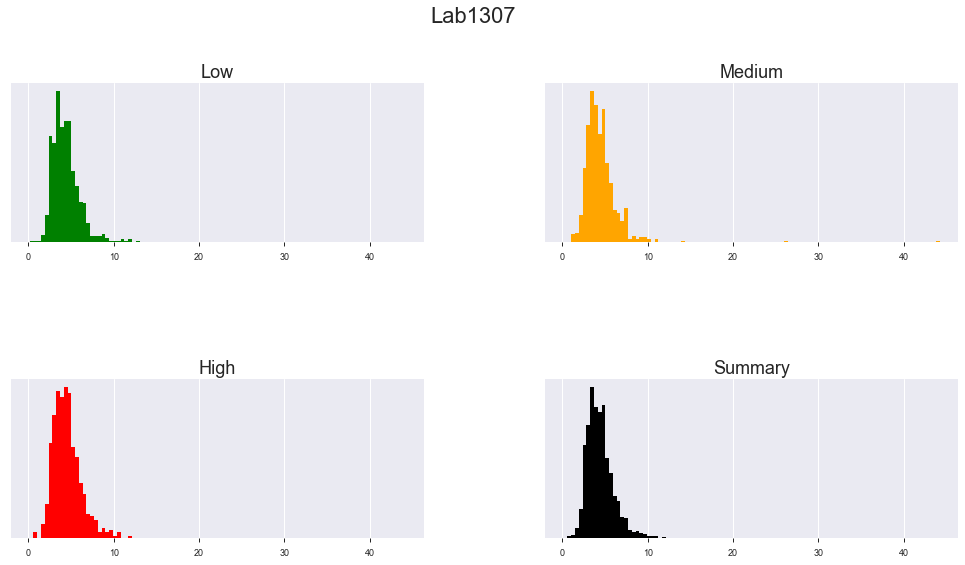

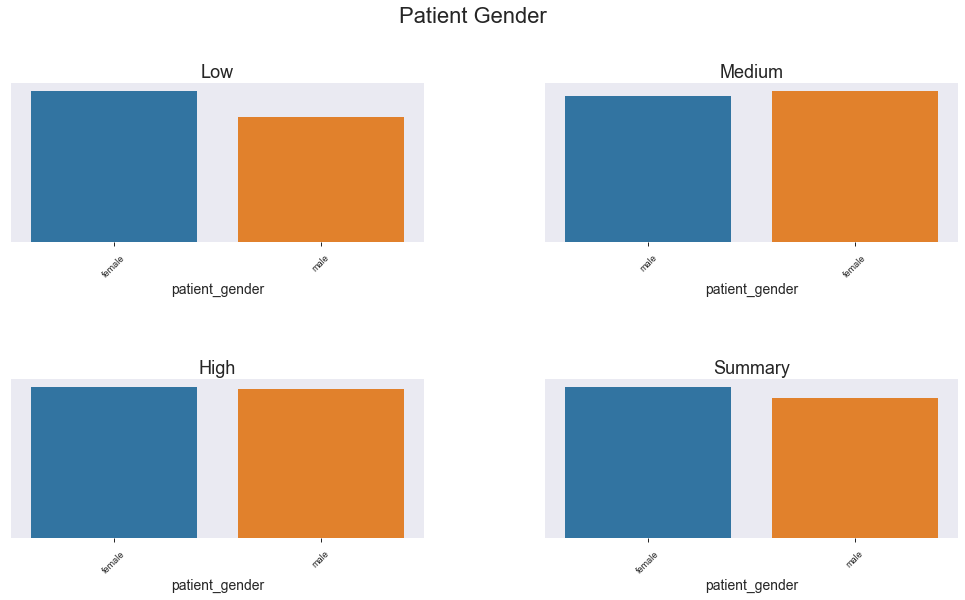

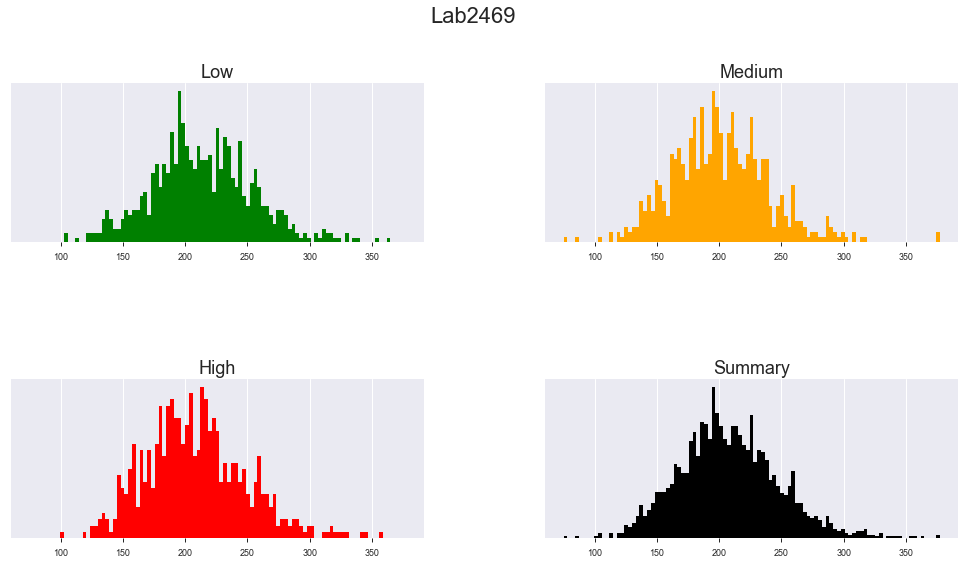

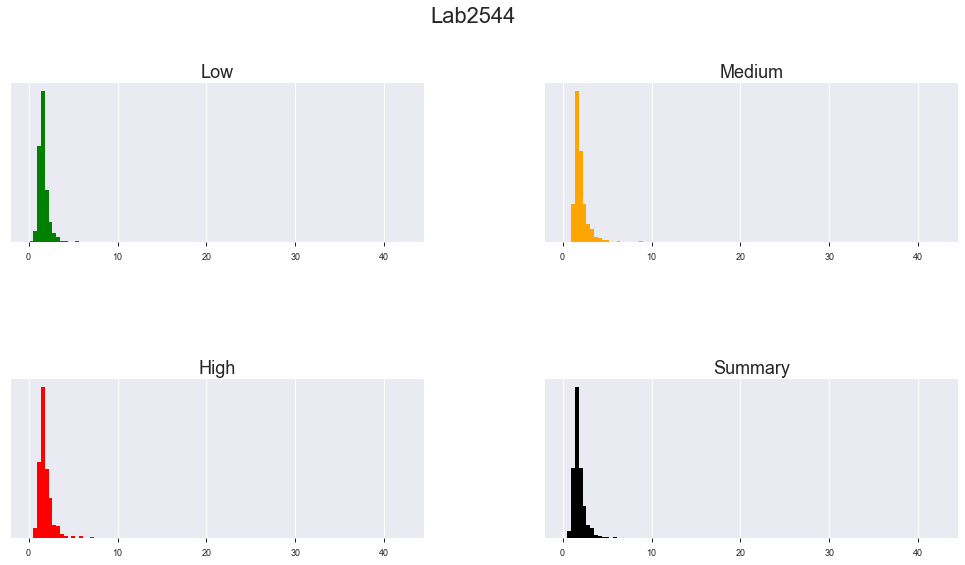

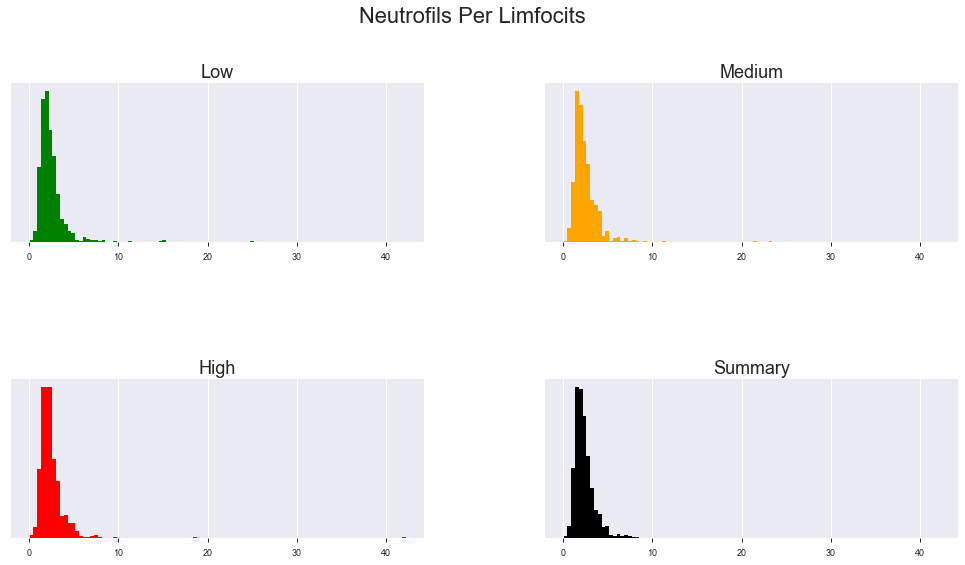

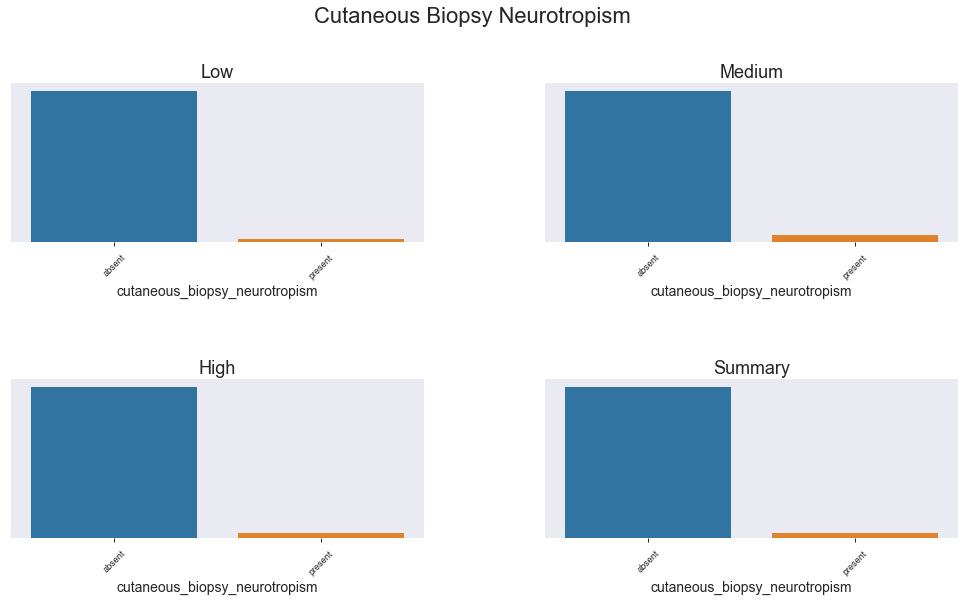

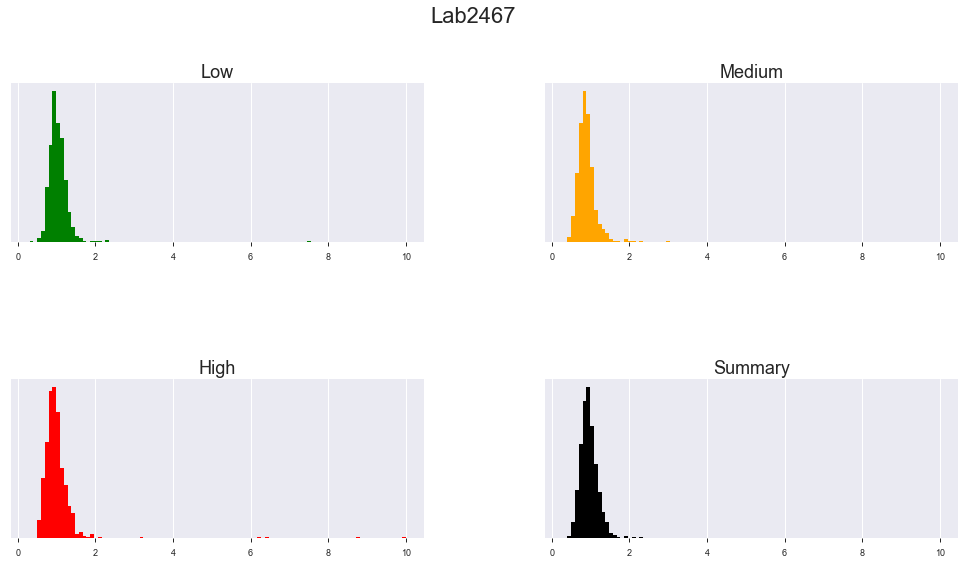

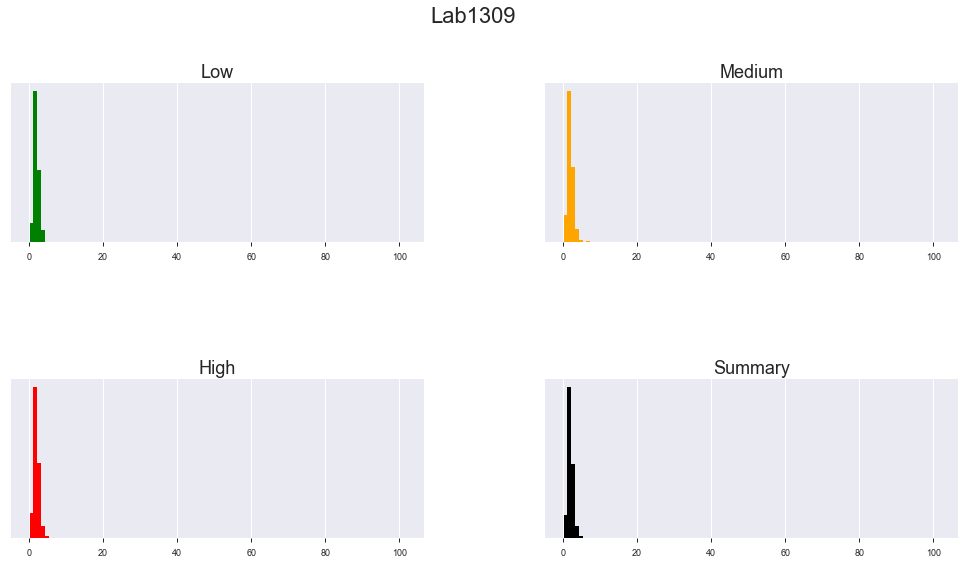

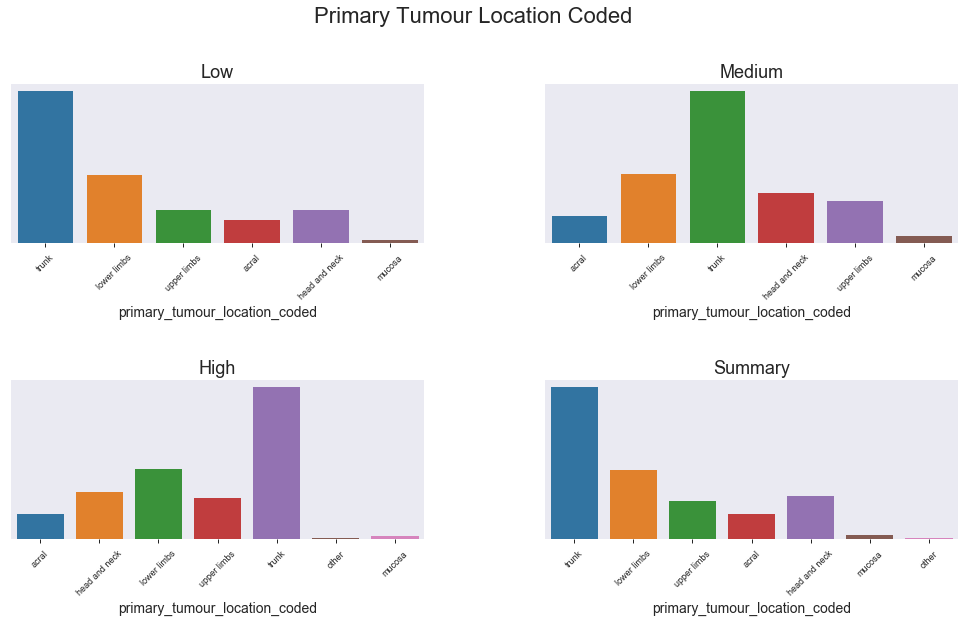

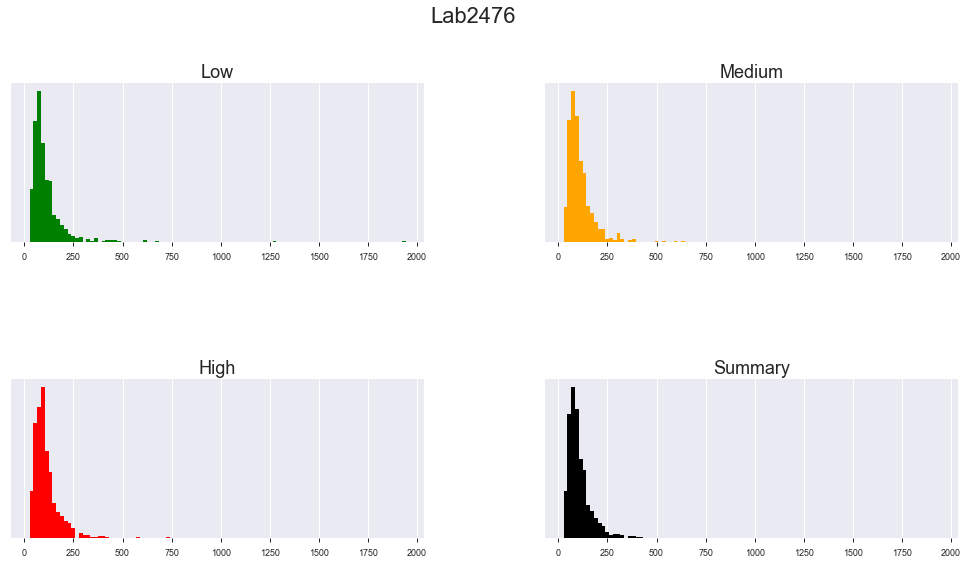

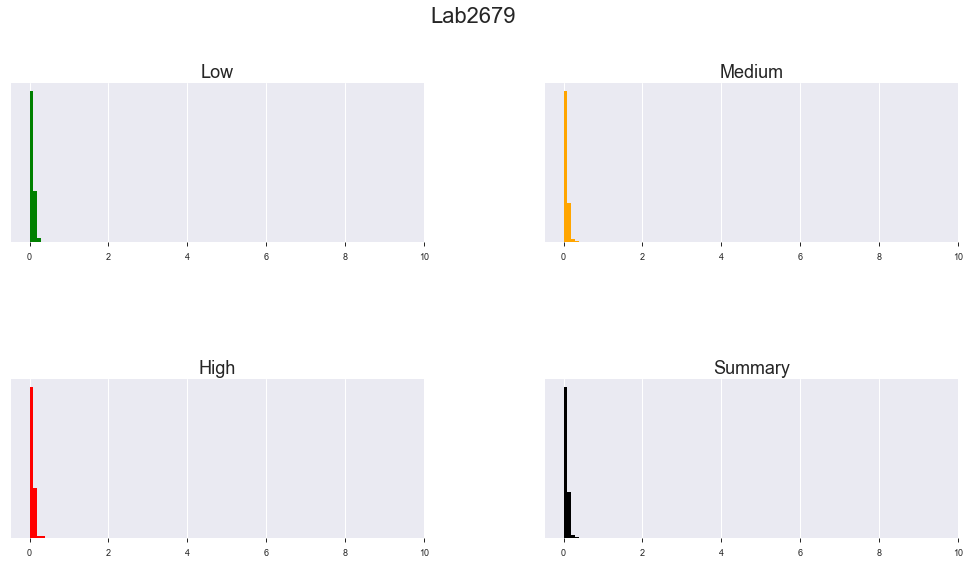

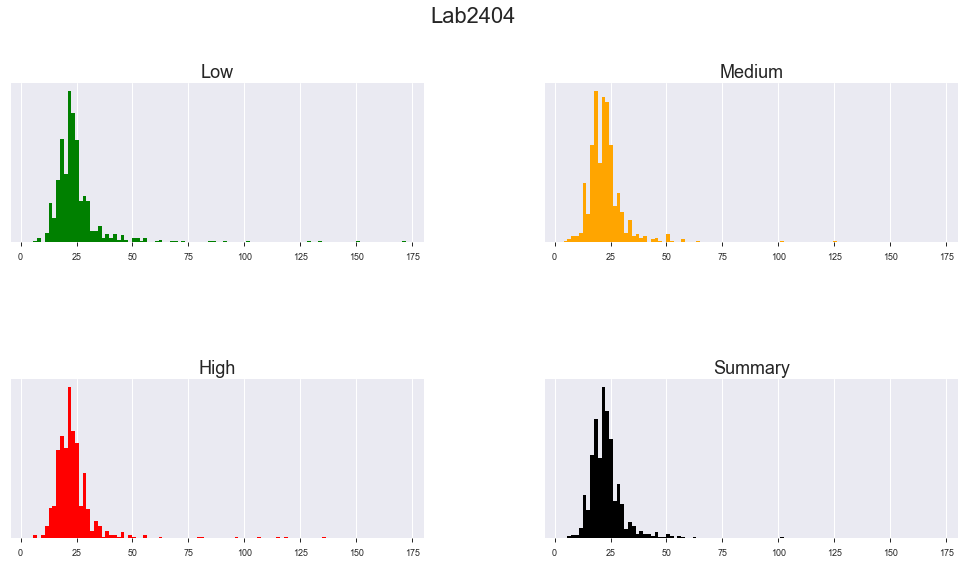

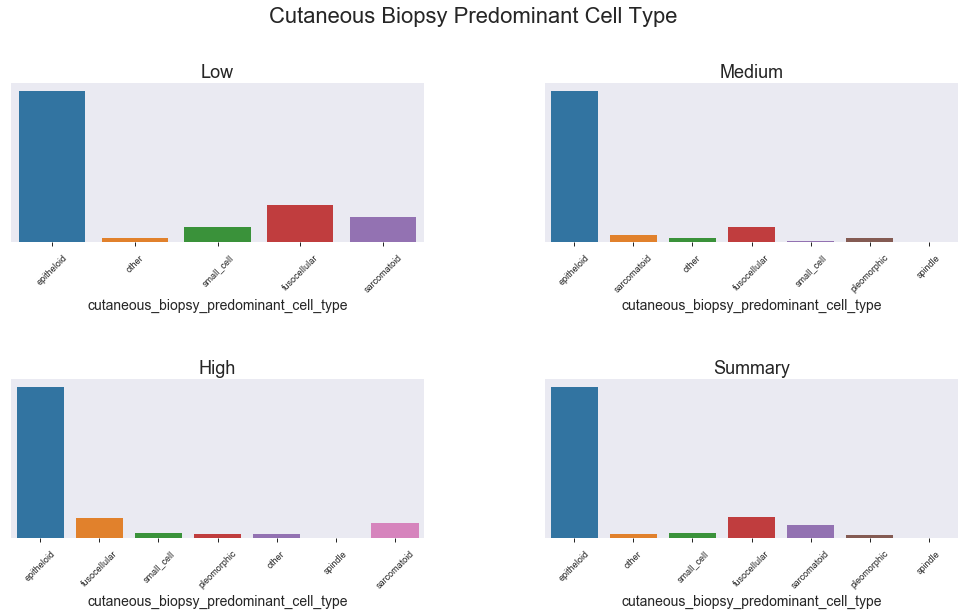

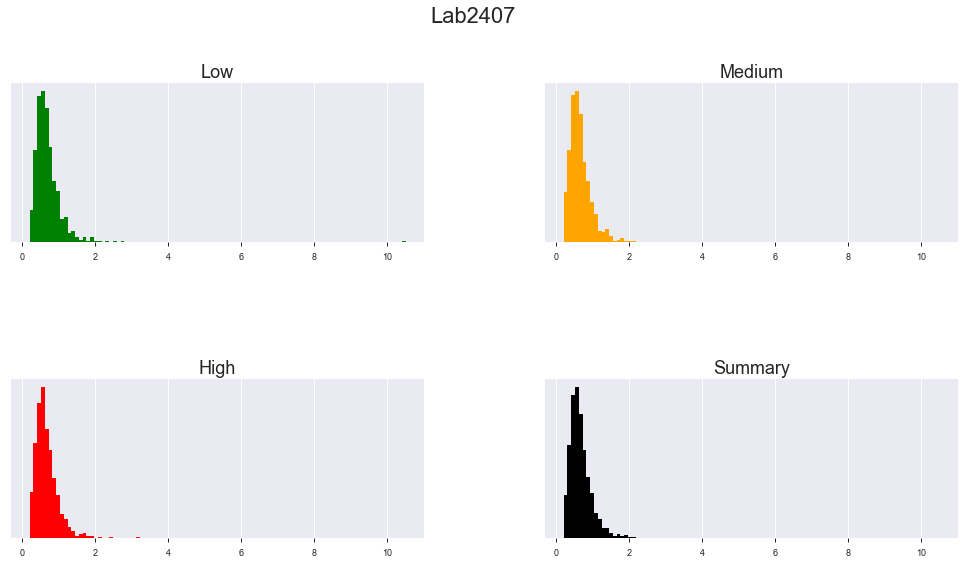

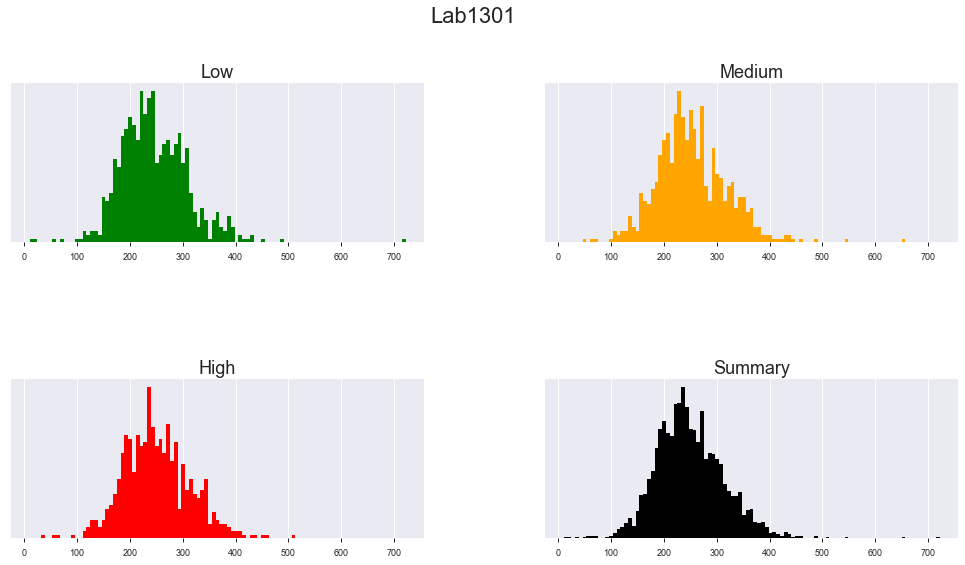

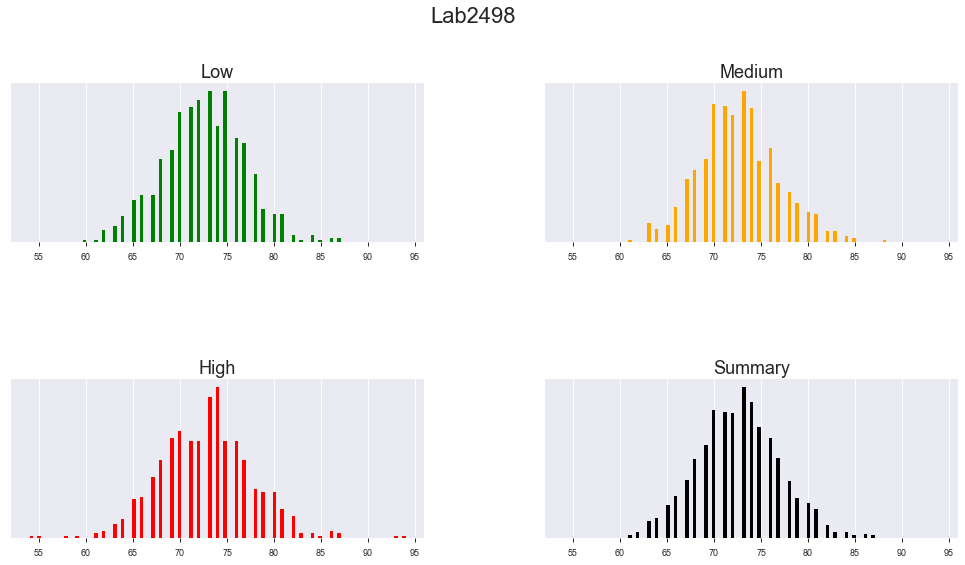

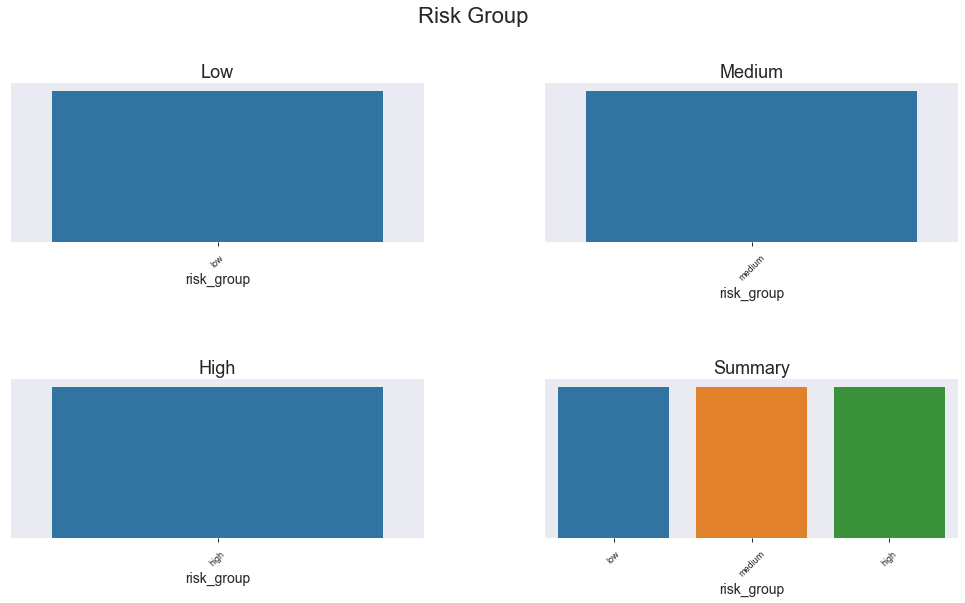

In [241]:
cols = list(csv.columns)
cols.remove("ID")
for c in cols:
    if c == "risk_group":
        continue
    plot(csv, c)